Character learning has two components.  First, we need to learn the structure of the automaton representing the automaton.  ProbFOIL, a relational learning library built on top of ProbLog, seems a natural choice---at any rate, it remains for future work.

Once we have a structure, we can fit parameters to that structure.  Example parameters include the dynamics of each state and any parameters on guards.  Since we only consider one character at a time, we can abstract the environment into occluding collisions, non-occluding collisions, and hostile collisions.

We'll work with non-hierarchical, non-concurrent hybrid automata for now.  Also, we'll assume left and right movement are mirrored.  Our representation of a state will define, for each variable, whether it has a constant velocity or a constant acceleration (and what that value is); and what transitions are available under what circumstances (a conjunction of abstracted inputs, continuous variable thresholds, timers, any collisions of any type at any normal to the character, and negations of the same).  A state machine is a set of states and an initial state.

In [7]:
%matplotlib inline

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns
#from ipywidgets import interactive, fixed

import numpy as np
import pandas as pd


import theano

import jumpfinder
from jumpfinder import hold, marioGetX, marioGetY, metroidGetX, metroidGetY
import fceulib

In [8]:
RIGHT = 1 << 7
LEFT = 1 << 6
DOWN = 1 << 5
UP = 1 << 4
START = 1 << 3
SELECT = 1 << 2
B = 1 << 1
A = 1 << 0

mario_x = 0x006D
mario_y = 0x00CE

metroid_x = 0x0051
metroid_y = 0x0052

In [3]:
jumpButton = A
games = {
    "mario": (
        "mario.nes",
        (hold(0x0, 120) + hold(START | jumpButton, 30) +
         hold(0x0, 150)),
        marioGetX,
        marioGetY
    ),
    "metroid": (
        "metroid.nes",
        (hold(0x0, 60) + hold(START, 1) + hold(0x0, 15) +
         hold(START, 1) + hold(0x0, 600) + hold(LEFT, 400) +
         hold(RIGHT, 30)),
        metroidGetX,
        metroidGetY
    )
}
(game, startInputs, getx, gety) = games["mario"]
total = 0
emu = fceulib.runGame(game)
for m in startInputs:
    total = total + 1
    emu.step(m, 0x0)

emu.step(0x0, 0x0)
start = fceulib.VectorBytes()
emu.save(start)
trials = jumpfinder.runTrials(emu, start, getx, gety, jumpButton)

Let's learn two linear velocity models: One for ascents and one for descents.

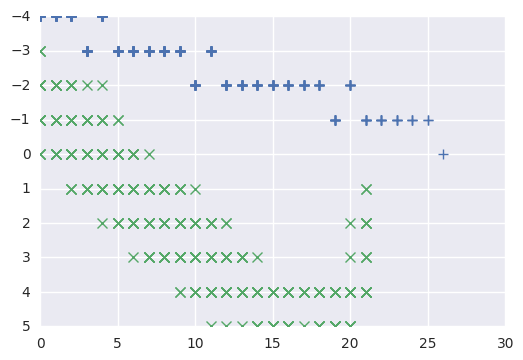

In [10]:
data = dict(rx=np.array([]),ry=np.array([]),fx=np.array([]),fy=np.array([]))
# FIXME: This is wrong.  Better would be to concatenate the trials, have an Intercept var for each break point and use one of the three slopes (need a third for ground state).
#        We know which slope to use because we have our a priori knowledge of the current state.  This is a good opportunity to generalize a little bit to arbitrary numbers
#        of modes.
for moves,stats in trials[5:]:
    rising = True
    fallStart = 0
    for i,m in enumerate(moves):
        if rising and not (m & jumpButton):
            rising = False
            fallStart = i
        if rising:
            data["rx"] = np.append(data["rx"],i)
            data["ry"] = np.append(data["ry"],(stats.y.allVals[i+1] - stats.y.allVals[i]))
        else:
            data["fx"] = np.append(data["fx"],(i - fallStart))
            data["fy"] = np.append(data["fy"], (stats.y.allVals[i+1] - stats.y.allVals[i]))
plt.plot(data["rx"],data["ry"],"+",markeredgewidth=1)
plt.plot(data["fx"],data["fy"],"x",markeredgewidth=1)
plt.gca().invert_yaxis()
plt.show()

In [19]:
data["ry"][20:30]

array([-3., -4., -4., -4., -3., -4., -3., -3., -3., -3.])

In [5]:
# TODO: Also interested in exploring learning accelerations and v0s by fitting a quadratic model, but not sure how to set up the input data for that.

with pm.Model() as model:
    sigma1 = pm.HalfCauchy('sigma1', beta=10, testval=1.)
    intercept1 = pm.Normal('Intercept1', 0, sd=20)
    x_coeff1 = pm.Normal('rx', 0, sd=20)
    
    # Define likelihood
    likelihood1 = pm.Normal('ry', mu=intercept1 + x_coeff1 * data["rx"], 
                            sd=sigma1, observed=data["ry"])
    

    sigma2 = pm.HalfCauchy('sigma2', beta=10, testval=1.)
    intercept2 = pm.Normal('Intercept2', 0, sd=20)
    x_coeff2 = pm.Normal('fx', 0, sd=20)
    
    # Define likelihood
    likelihood2 = pm.Normal('fy', mu=intercept2 + x_coeff2 * data["fx"], 
                            sd=sigma2, observed=data["fy"])

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step, progressbar=True)


100%|██████████| 2000/2000 [00:02<00:00, 791.76it/s]

 96%|█████████▌| 1915/2000 [00:02<00:00, 894.31it/s]

 91%|█████████ | 1821/2000 [00:02<00:00, 877.06it/s]

 87%|████████▋ | 1732/2000 [00:02<00:00, 873.55it/s]

 82%|████████▏ | 1640/2000 [00:02<00:00, 858.30it/s]

 77%|███████▋  | 1546/2000 [00:02<00:00, 834.48it/s]

 73%|███████▎  | 1456/2000 [00:01<00:00, 810.18it/s]

 69%|██████▊   | 1373/2000 [00:01<00:00, 818.60it/s]

 64%|██████▍   | 1289/2000 [00:01<00:00, 812.93it/s]

 60%|██████    | 1204/2000 [00:01<00:00, 803.11it/s]

 56%|█████▌    | 1117/2000 [00:01<00:01, 778.50it/s]

 52%|█████▏    | 1034/2000 [00:01<00:01, 759.98it/s]

 48%|████▊     | 956/2000 [00:01<00:01, 772.33it/s]

 44%|████▍     | 876/2000 [00:01<00:01, 763.66it/s]

 40%|███▉      | 798/2000 [00:01<00:01, 757.11it/s]

 36%|███▌      | 712/2000 [00:01<00:01, 720.85it/s]

 32%|███▏      | 639/2000 [00:00<00:01, 724.82it/s]

 28%|██▊       | 562/2000 [00:00<00:02, 713.54it/s]

 24%|██▍       | 478/2000 [00:00<00:02, 673.75it/s]

 20%|██        | 401/2000 [00:00<00:02, 644.81it/s]

 16%|█▋        | 330/2000 [00:00<00:02, 620.48it/s]

 13%|█▎        | 260/2000 [00:00<00:02, 595.20it/s]

  9%|▉         | 182/2000 [00:00<00:03, 541.38it/s]

  5%|▌         | 107/2000 [00:00<00:03, 483.99it/s]

  2%|▏         | 45/2000 [00:00<00:04, 445.36it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Applied log-transform to sigma2 and added transformed sigma2_log_ to model.


Applied log-transform to sigma1 and added transformed sigma1_log_ to model.


In [0]:
trace

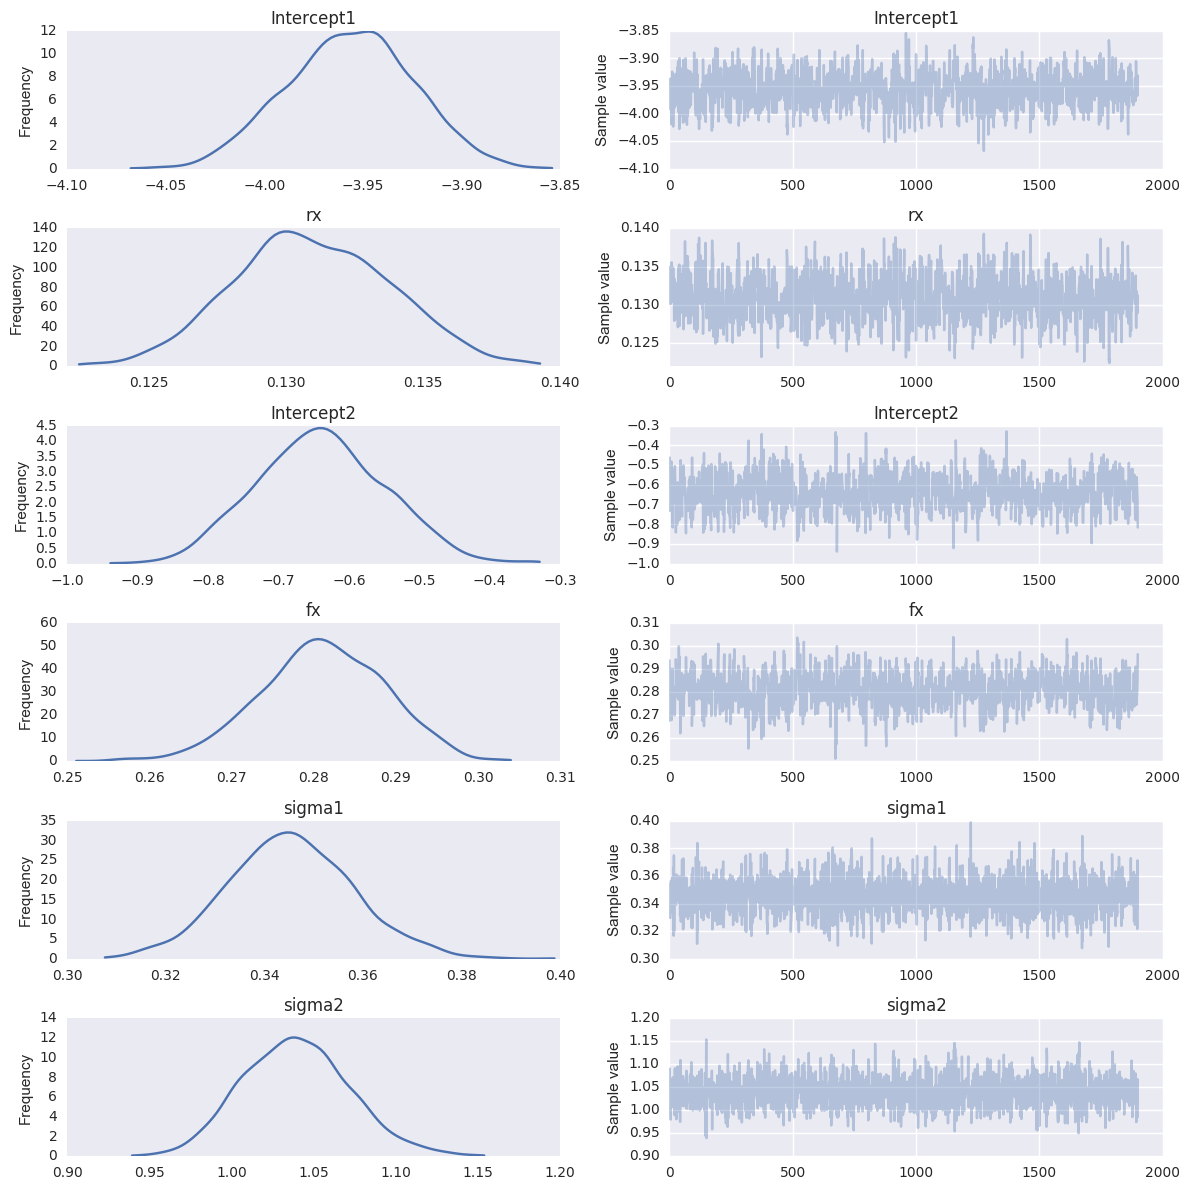

In [11]:
plt.figure(figsize=(6, 6))
pm.traceplot(trace[100:])
plt.tight_layout();

In [0]:
pm.glm.plot_posterior_predictive(trace, eval=data["rx"], samples=100, label='posterior predictive regression lines')
plt.plot(data["rx"], data["ry"])

In [0]:
model.cont_vars

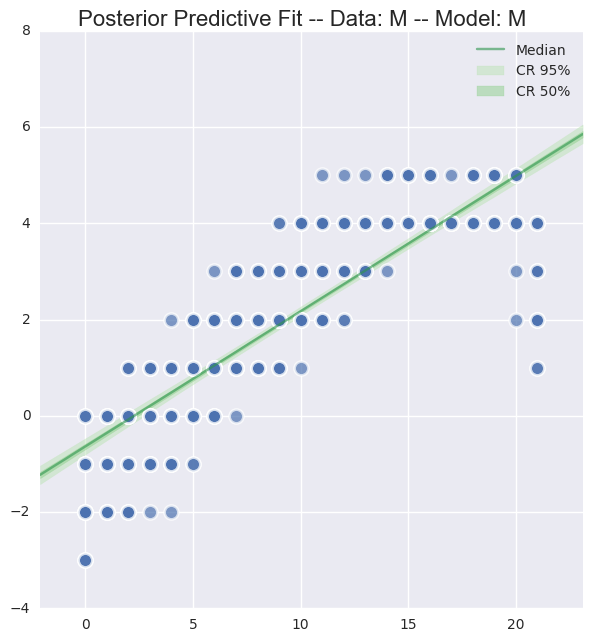

In [12]:
modelnm = "M"
datamodelnm = "M"
npoints = 100
xc = "fx"
ic = "Intercept2"
yc = "fy"
mdl = model
trc = pm.trace_to_dataframe(trace[-1000:])
trc = trc[[ic,xc]]

ordr = 1
xlims = (data[xc].min() - np.ptp(data[xc])/10,
         data[xc].max() + np.ptp(data[xc])/10)

x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
pwrs = np.ones((npoints,ordr+1)) * np.arange(ordr+1)
X = x ** pwrs
cr = np.dot(X,trc.T)

## Calculate credible regions and plot over the datapoints
dfp = pd.DataFrame(np.percentile(cr,[2.5, 25, 50, 75, 97.5], axis=1).T,
                   columns=['025','250','500','750','975'])
dfp['x'] = x

pal = sns.color_palette('Greens')

f, ax1d = plt.subplots(1,1, figsize=(7,7))
f.suptitle('Posterior Predictive Fit -- Data: {} -- Model: {}'.format(
    datamodelnm, modelnm), fontsize=16)
plt.subplots_adjust(top=0.95)
ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                  ,color=pal[1], label='CR 95%')
ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.5
                  ,color=pal[2], label='CR 50%')
ax1d.plot(dfp['x'], dfp['500'], alpha=0.6, color=pal[4], label='Median')
_ = plt.legend()
_ = ax1d.set_xlim(xlims)
_ = sns.regplot(x=xc, y=yc, data=data, fit_reg=False
                ,scatter_kws={'alpha':0.7,'s':100, 'lw':2,'edgecolor':'w'}, ax=ax1d)


In [0]:
pm.stats.dic(model=model,trace=trace)
